In [138]:
# Import libraries
import pandas as pd
import numpy as np 
from simple_colors import *

import string
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

# model liberies
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import auc, roc_curve, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import warnings

warnings.filterwarnings('ignore')

In [ ]:
### Review

In [2]:
df_train = pd.read_csv('train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
print('There are {} rows and {} columns in this train dataset.'.format(df_train.shape[0],df_train.shape[1]))

There are 7613 rows and 5 columns in this train dataset.


## EDA: Part 1

In [4]:
# Find the instance difference in the target class
print('This train set contains {} instance of no disaster target'.format(len(df_train.loc[df_train['target'] == 0])))
print('This train set contains {} instance of disaster target'.format(len(df_train.loc[df_train['target'] == 1])))

This train set contains 4342 instance of no disaster target
This train set contains 3271 instance of disaster target


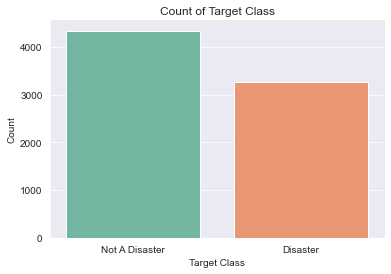

In [5]:
sns.set_style('darkgrid')
sns.set_palette('Set2')

plot = sns.countplot(data=df_train, x='target')
plt.title('Count of Target Class')
plt.xlabel('Target Class')
plt.ylabel('Count')
plot.set_xticklabels(['Not A Disaster', 'Disaster'])

sns.despine()
plt.show()

In [6]:
# Creating a new feature to determine the length of a text
def textlength(text):
    """A function to determine the length of text"""
    return len(text)

In [7]:
df_train['length_txt'] = df_train['text'].apply(textlength)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   length_txt  7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


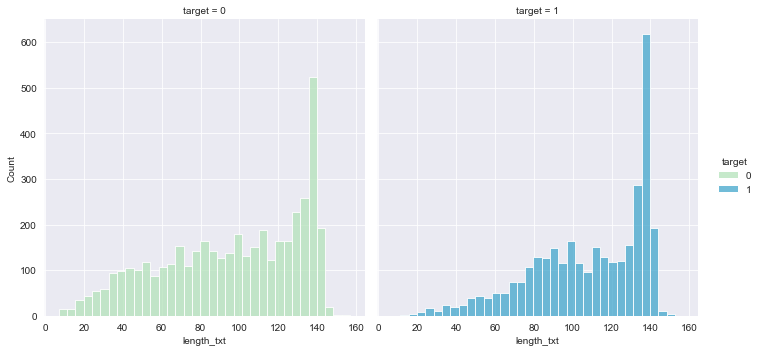

In [8]:
# Finding the distribution of text length between target class
sns.displot(data=df_train, x='length_txt', bins=35, hue='target', col='target', palette='GnBu')

In [9]:
# This is showing me that the length of text is not a great feature to seperate the classes.
# However, there are more smaller length text that show that there is no disaster. 

In [10]:
# The next step to my process is examining the puncuation for each target class
# 1. Create a corpus function to make a corpus for each target.
# 2. Find which puncuation is important for each target, demonstrate with a visual

def create_corpus(target, column):
    """This function was created to create a corpus based on the target class you select"""
    corpus = []
    
    if column == 'text':
        for x in df_train[df_train.target == target][column].str.split():
            for i in x:
                corpus.append(i)
    else:
        for x in df_train[df_train.target == target][column]:
            for i in x:
                corpus.append(i)
    return corpus

In [11]:
# Remove '-' & from the analysis
def dic_punctuation(target):
    """A function that uses a corpus with a selected class and analyzes the count of punctuations"""
    corpus= create_corpus(target, 'text')
    
    dic=defaultdict(int)
    special = string.punctuation
    for word in corpus:
        if word in special:
            dic[word]+=1
    # Remove '-' from the analysis
    del dic['-']
    
    sorted_tuples = sorted(dic.items(), key= lambda item:item[1])
    dic = {k: v for k, v in sorted_tuples}
    
    return dic

Text(0.5, 1.0, 'Punctuations for a Disaster')

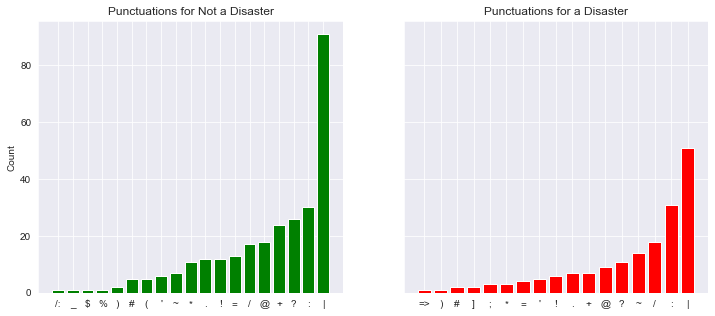

In [12]:
dic = dic_punctuation(0)
x, y=zip(*dic.items())

dic1 = dic_punctuation(1)
x1, y1=zip(*dic1.items())

fig, (axe1, axe2)= plt.subplots(1,2,sharey=True, figsize=(12,5))
axe1.bar(x,y,color='g')
axe1.set_title('Punctuations for Not a Disaster')
axe1.set_ylabel('Count')

axe2.bar(x1,y1,color='r')
axe2.set_title('Punctuations for a Disaster')


In [13]:
# I dont see any important difference and the amount of punctuations relative to the sample size for each target is less
# than 2%. Moving forward I will remove all the punctuations.

<FreqDist with 20560 samples and 63848 outcomes>


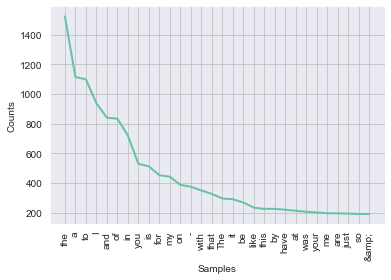

In [14]:
corpus= create_corpus(0, 'text')
fdist = FreqDist(corpus)
print(fdist)

# Frequency Distribution Plot
fdist.plot(30,cumulative=False)
plt.show()

<FreqDist with 16150 samples and 49613 outcomes>


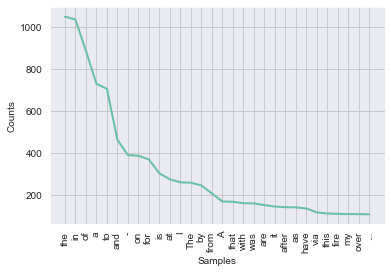

In [15]:
corpus= create_corpus(1, 'text')
fdist = FreqDist(corpus)
print(fdist)

# Frequency Distribution Plot
fdist.plot(30,cumulative=False)
plt.show()

In [16]:
## Need to analysis Nouns to see if wee remove them with stop words

## Tokenization

In [17]:
def sent_token(text):
    """Performs a sentence tokenization"""
    return sent_tokenize(text)
def word_token(text):
    """Performs a word Tokenization"""
    return word_tokenize(text)

df_train['sent_tokens'] = df_train['text'].apply(sent_token)
df_train['sent_tokens_len'] = df_train['sent_tokens'].apply(textlength)

df_train['word_tokens'] = df_train['text'].apply(word_token)
df_train['word_tokens_len'] = df_train['word_tokens'].apply(textlength)

df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  length_txt                                        sent_tokens  \
0       1          69  [Our Deeds are the Reason of this #earthquake ...   
1       1          38          [Forest fire near La Ronge Sask., Canada]   
2       1         133  [All residents asked to 'shelter in place' are...   
3       1          65  [13,000 people receive #wildfires evacuation o...   
4       1          88  [Just got sent this photo from Ruby #Alaska as...   

   sent_tokens_len                                        word_tokens  \
0                1  [Our, Deeds, are, the, Reason, of, this, #, ea...   
1                2   [Forest, fire, near, La, Ronge, Sask, ., Canada]   
2                2  [All, residents, asked, to, 'shelter, in, plac...   
3                1  [13,000, people, receive, #, wildfires, evacua...   
4                1  [Just, got, sent, this, photo, from, Ruby, #, ...   

   word_tokens_len  
0               14  
1                8  
2               24  
3                9  
4               18

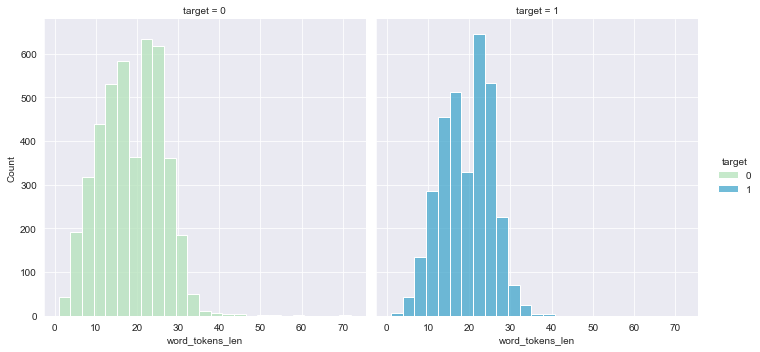

In [18]:
# Finding the distribution of text length between target class
sns.displot(data=df_train, x='word_tokens_len', bins=25, hue='target', col='target', palette='GnBu')

## Preprocessing text
 1. Lower Case, Removal of puncuation, Removal of stopwords
 2. Stemming and Lemmatization

In [19]:
stop_words = stopwords.words('english')

# Extending the stopwords list to include punctuations
stop_words.extend(string.punctuation)

# Will be removing ... http 
stop_words.extend(['...', 'http', 'https'])

def preprocessing(text):
    """A function that will clean each tweet by lower casing, removing punctuations and remove stopwords"""
    return [word.lower() for word in text if (word not in stop_words) and len(word) > 2]  

In [20]:
df_train['preprocessed_text'] = df_train['word_tokens'].apply(preprocessing)
df_train['preprocessed_text'] = df_train['preprocessed_text'].apply(preprocessing)

In [21]:
df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  length_txt                                        sent_tokens  \
0       1          69  [Our Deeds are the Reason of this #earthquake ...   
1       1          38          [Forest fire near La Ronge Sask., Canada]   
2       1         133  [All residents asked to 'shelter in place' are...   
3       1          65  [13,000 people receive #wildfires evacuation o...   
4       1          88  [Just got sent this photo from Ruby #Alaska as...   

   sent_tokens_len                                        word_tokens  \
0                1  [Our, Deeds, are, the, Reason, of, this, #, ea...   
1                2   [Forest, fire, near, La, Ronge, Sask, ., Canada]   
2                2  [All, residents, asked, to, 'shelter, in, plac...   
3                1  [13,000, people, receive, #, wildfires, evacua...   
4                1  [Just, got, sent, this, photo, from, Ruby, #, ...   

   word_tokens_len                                  preprocessed_text  
0               14   [deeds, reason, earthquake, may, allah, forgive]  
1                8          [forest, fire, near, ronge, sask, canada]  
2               24  [residents, asked, 'shelter, place, notified, ...  
3                9  [13,000, people, receive, wildfires, evacuatio...  
4               18  [got, sent, photo, ruby, alaska, smoke, wildfi...

### Stemming

In [22]:
#Stemming
snowball_stemmer = nltk.SnowballStemmer('english')

def stemming_text(text):
    return [snowball_stemmer.stem(word) for word in text]

df_train['filtered_stemming'] = df_train['preprocessed_text'].apply(stemming_text)

df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  length_txt                                        sent_tokens  \
0       1          69  [Our Deeds are the Reason of this #earthquake ...   
1       1          38          [Forest fire near La Ronge Sask., Canada]   
2       1         133  [All residents asked to 'shelter in place' are...   
3       1          65  [13,000 people receive #wildfires evacuation o...   
4       1          88  [Just got sent this photo from Ruby #Alaska as...   

   sent_tokens_len                                        word_tokens  \
0                1  [Our, Deeds, are, the, Reason, of, this, #, ea...   
1                2   [Forest, fire, near, La, Ronge, Sask, ., Canada]   
2                2  [All, residents, asked, to, 'shelter, in, plac...   
3                1  [13,000, people, receive, #, wildfires, evacua...   
4                1  [Just, got, sent, this, photo, from, Ruby, #, ...   

   word_tokens_len                                  preprocessed_text  \
0               14   [deeds, reason, earthquake, may, allah, forgive]   
1                8          [forest, fire, near, ronge, sask, canada]   
2               24  [residents, asked, 'shelter, place, notified, ...   
3                9  [13,000, people, receive, wildfires, evacuatio...   
4               18  [got, sent, photo, ruby, alaska, smoke, wildfi...   

                                   filtered_stemming  
0      [deed, reason, earthquak, may, allah, forgiv]  
1           [forest, fire, near, rong, sask, canada]  
2  [resid, ask, shelter, place, notifi, offic, ev...  
3  [13,000, peopl, receiv, wildfir, evacu, order,...  
4  [got, sent, photo, rubi, alaska, smoke, wildfi...

### Lemmatization

In [23]:
df_train['pos_tag'] = df_train['preprocessed_text'].apply(nltk.pos_tag)

In [24]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [25]:
def lemmatize_text_pos(text_pos):
    res = []
    lemmatizer = WordNetLemmatizer()
    # get word and its pos
    for word, pos in text_pos:
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        res.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
    return res

In [26]:
df_train['filtered_lemmatize'] = df_train['pos_tag'].apply(lemmatize_text_pos)

In [27]:
df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  length_txt                                        sent_tokens  \
0       1          69  [Our Deeds are the Reason of this #earthquake ...   
1       1          38          [Forest fire near La Ronge Sask., Canada]   
2       1         133  [All residents asked to 'shelter in place' are...   
3       1          65  [13,000 people receive #wildfires evacuation o...   
4       1          88  [Just got sent this photo from Ruby #Alaska as...   

   sent_tokens_len                                        word_tokens  \
0                1  [Our, Deeds, are, the, Reason, of, this, #, ea...   
1                2   [Forest, fire, near, La, Ronge, Sask, ., Canada]   
2                2  [All, residents, asked, to, 'shelter, in, plac...   
3                1  [13,000, people, receive, #, wildfires, evacua...   
4                1  [Just, got, sent, this, photo, from, Ruby, #, ...   

   word_tokens_len                                  preprocessed_text  \
0               14   [deeds, reason, earthquake, may, allah, forgive]   
1                8          [forest, fire, near, ronge, sask, canada]   
2               24  [residents, asked, 'shelter, place, notified, ...   
3                9  [13,000, people, receive, wildfires, evacuatio...   
4               18  [got, sent, photo, ruby, alaska, smoke, wildfi...   

                                   filtered_stemming  \
0      [deed, reason, earthquak, may, allah, forgiv]   
1           [forest, fire, near, rong, sask, canada]   
2  [resid, ask, shelter, place, notifi, offic, ev...   
3  [13,000, peopl, receiv, wildfir, evacu, order,...   
4  [got, sent, photo, rubi, alaska, smoke, wildfi...   

                                             pos_tag  \
0  [(deeds, NNS), (reason, NN), (earthquake, NN),...   
1  [(forest, JJS), (fire, NN), (near, IN), (ronge...   
2  [(residents, NNS), (asked, VBD), ('shelter, JJ...   
3  [(13,000, CD), (people, NNS), (receive, JJ), (...   
4  [(got, VBD), (sent, JJ), (photo, NN), (ruby, N...   

                                  filtered_lemmatize  
0    [deed, reason, earthquake, may, allah, forgive]  
1          [forest, fire, near, ronge, sask, canada]  
2  [resident, ask, 'shelter, place, notify, offic...  
3  [13,000, people, receive, wildfire, evacuation...  
4  [get, sent, photo, ruby, alaska, smoke, wildfi...

## EDA 2 : Analysis after preprocess

In [28]:
corpus_preprocessed = create_corpus(0, 'preprocessed_text')
pof_0 = nltk.pos_tag(corpus_preprocessed)

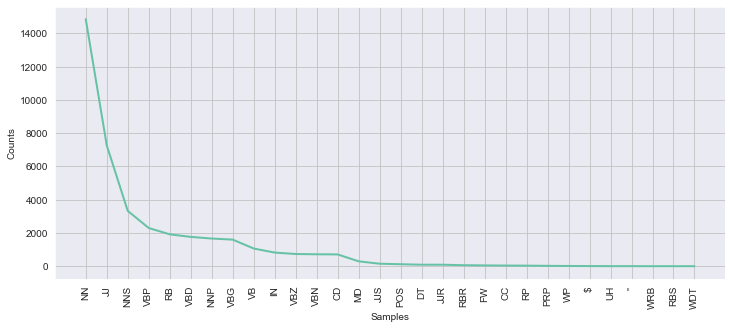

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [29]:
pof_names0 = []
for i in range(len(pof_0)):
    pof_names0.append(pof_0[i][1])

pof_dis_0 = FreqDist(pof_names0)
plt.figure(figsize=(12,5))
pof_dis_0.plot(30, cumulative=False)

In [30]:
corpus_preprocessed = create_corpus(1, 'preprocessed_text')
pof_1 = nltk.pos_tag(corpus_preprocessed)

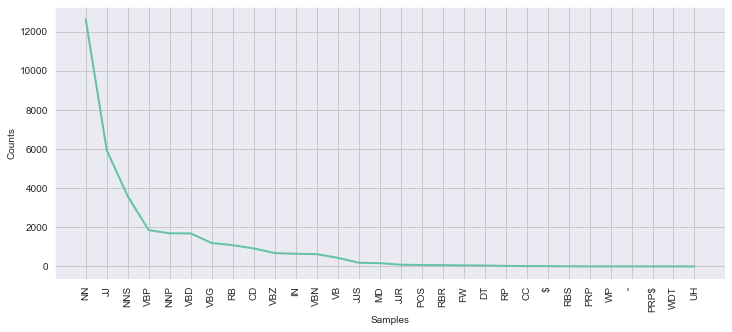

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [31]:
pof_names1 = []
for i in range(len(pof_1)):
    pof_names1.append(pof_1[i][1])

pof_dis_1 = FreqDist(pof_names1)
plt.figure(figsize=(12,5))
pof_dis_1.plot(30, cumulative=False)

In [32]:
df_train['filtered_lemmatize_len'] = df_train['filtered_lemmatize'].apply(textlength)

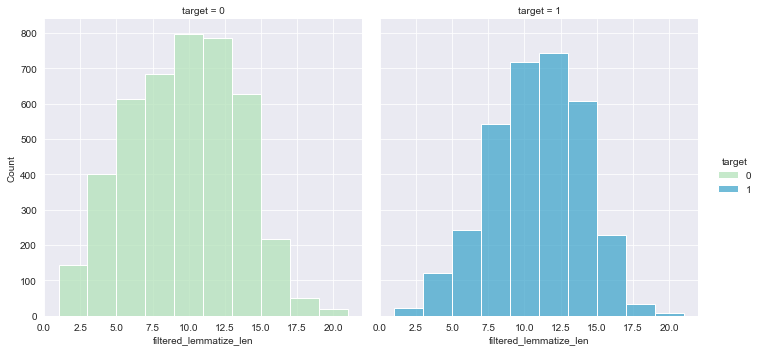

In [33]:
# Finding the distribution of text length between target class
sns.displot(data=df_train, x='filtered_lemmatize_len', bins=10, hue='target', col='target', palette='GnBu')

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generatewordcloud(corpus,types,cmap):
    if types == 'generate':
        wordcloud = WordCloud(background_color= 'black', width= 800, height= 400,
                              colormap= cmap,max_words= 180, contour_width= 3,
                              max_font_size= 80, contour_color= 'steelblue',
                              random_state= 0)
        wordcloud.generate(corpus)
    
        plt.figure(figsize=(15,8))
        plt.imshow(wordcloud, interpolation= 'bilinear')
        plt.axis('off')
        plt.figure()
        
    elif types == 'fit_words':
        wordcloud = WordCloud(background_color= 'black', width= 800, height= 400,
                              colormap= cmap,max_words= 180, contour_width= 3,
                              max_font_size= 80, contour_color= 'steelblue',
                              collocation_threshold = 3, random_state= 0)
        wordcloud.fit_words(corpus)
    
        plt.figure(figsize=(15,8))
        plt.imshow(wordcloud, interpolation= 'bilinear')
        plt.axis('off')
        plt.figure()        
    
    return wordcloud

In [35]:
corpus_preprocessed0 = create_corpus(0, 'filtered_lemmatize')
corpus0 = ' '.join(word for word in corpus_preprocessed0)
corpus_preprocessed1 = create_corpus(1, 'filtered_lemmatize')
corpus1 = ' '.join(word for word in corpus_preprocessed1)

326 n ' t
312 g e t
292 l i k e
209 a m p
172 n e w


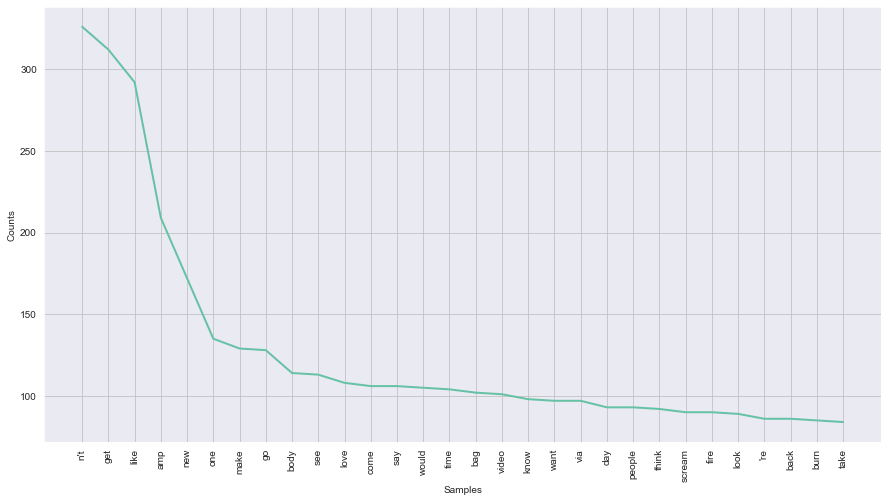

In [36]:
fdist0 = FreqDist(corpus_preprocessed0)

for words, count in fdist0.most_common(5):
    print(count, " ".join(list(words)))

# Frequency Distribution Plot
plt.figure(figsize=(15,8))
fdist0.plot(30,cumulative=False)
plt.show()

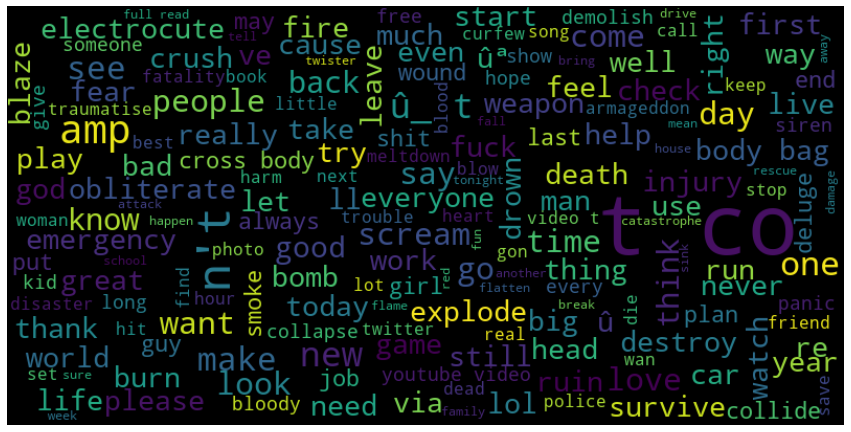

<Figure size 432x288 with 0 Axes>

In [37]:
generatewordcloud(corpus= corpus0,types='generate', cmap= 'viridis')

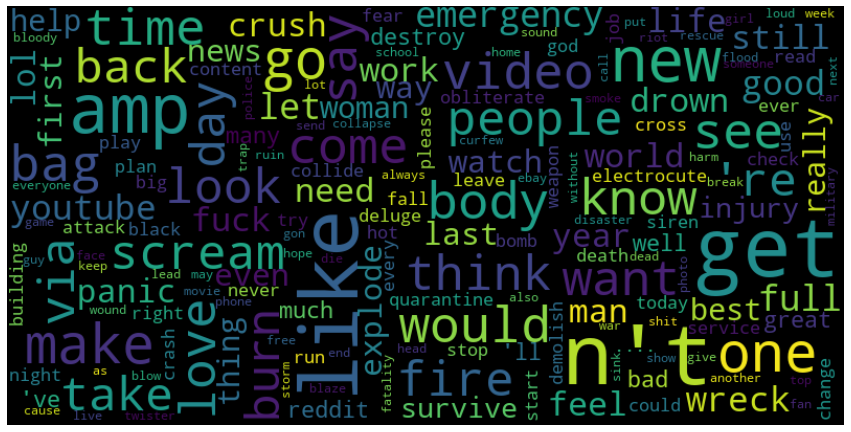

<Figure size 432x288 with 0 Axes>

In [38]:
generatewordcloud(corpus= fdist0,types='fit_words', cmap= 'viridis')

265 f i r e
155 k i l l
147 b o m b
140 n e w s
135 a m p


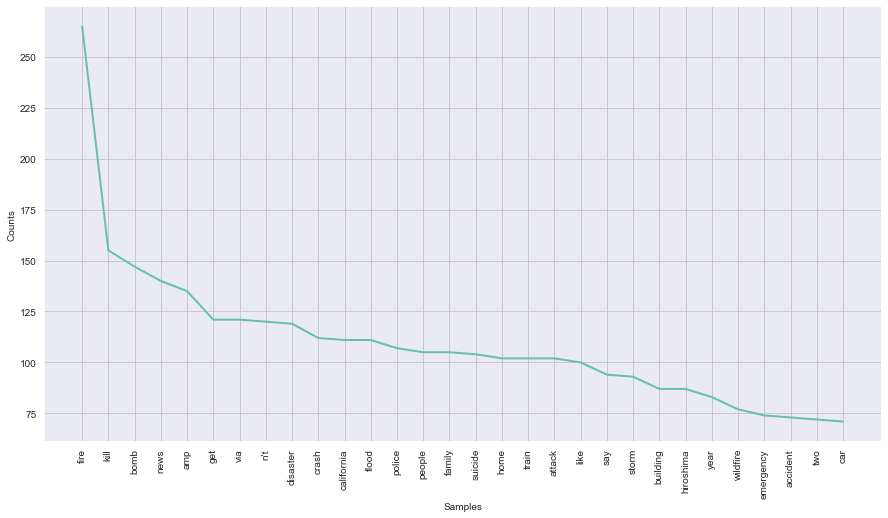

In [39]:
fdist1 = FreqDist(corpus_preprocessed1)

for words, count in fdist1.most_common(5):
    print(count, " ".join(list(words)))

# Frequency Distribution Plot
plt.figure(figsize=(15,8))
fdist1.plot(30,cumulative=False)
plt.show()

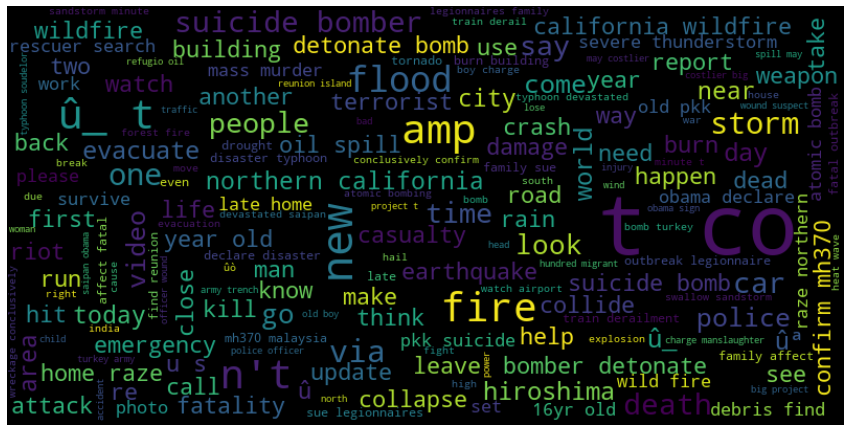

<Figure size 432x288 with 0 Axes>

In [40]:
generatewordcloud(corpus= corpus1,types='generate', cmap= 'viridis')

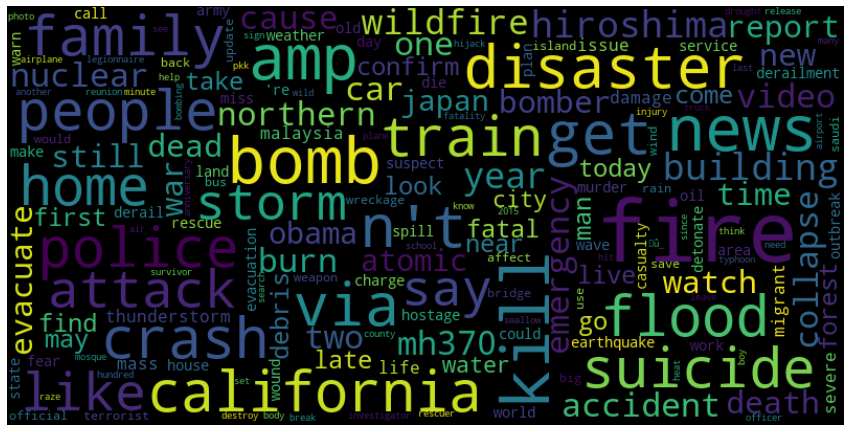

<Figure size 432x288 with 0 Axes>

In [41]:
generatewordcloud(corpus= fdist1,types='fit_words', cmap= 'viridis')

63 body bag
38 cross body
36 look like
36 youtube video
35 like youtube


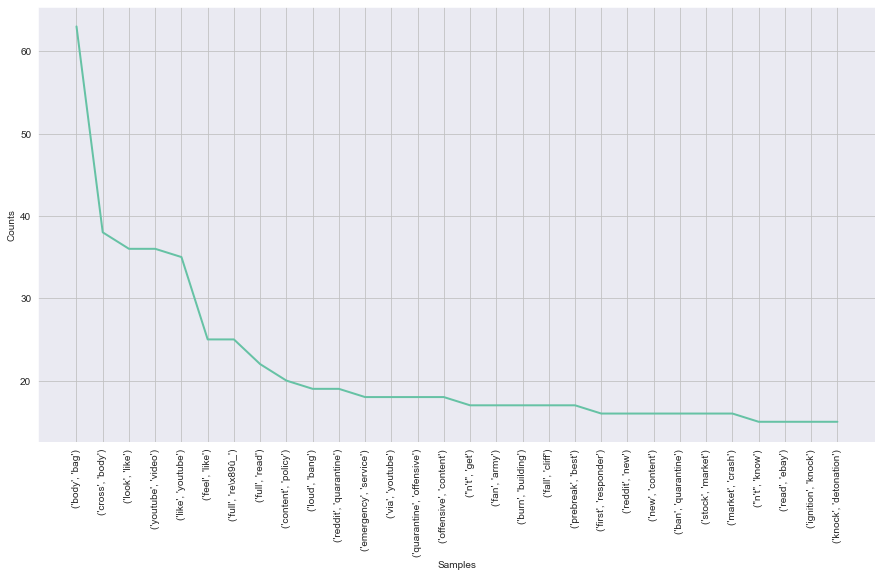

In [42]:
corpus_nostopwords = create_corpus(0, 'preprocessed_text')
bigrams0 = list(nltk.ngrams(corpus_preprocessed0, 2))

bigramsfreqs0 = FreqDist(bigrams0)
for words, count in bigramsfreqs0.most_common(5):
    print(count, " ".join(list(words)))
    
plt.figure(figsize=(15,8))
bigramsfreqs0.plot(30,cumulative=False)
plt.show()

In [43]:
bigramsfreqs0

FreqDist({('body', 'bag'): 63, ('cross', 'body'): 38, ('look', 'like'): 36, ('youtube', 'video'): 36, ('like', 'youtube'): 35, ('feel', 'like'): 25, ('full', 're\x89û_'): 25, ('full', 'read'): 22, ('content', 'policy'): 20, ('loud', 'bang'): 19, ...})

In [44]:
corpus_bigram = []
for i in range(len(bigrams0)):
    corpus_bigram.append(bigrams0[i][0]+'_'+bigrams0[i][1])
corpus_bigram0 = ' '.join(word for word in corpus_bigram)

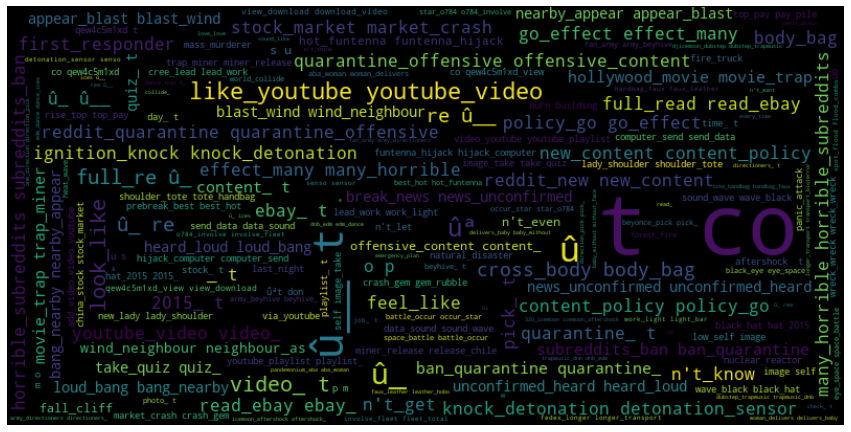

<Figure size 432x288 with 0 Axes>

In [45]:
generatewordcloud(corpus= corpus_bigram0,types='generate', cmap= 'viridis')

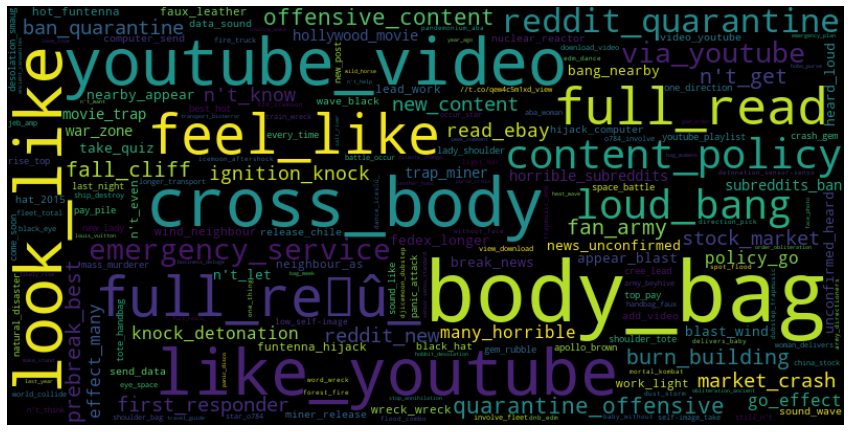

<Figure size 432x288 with 0 Axes>

In [46]:
corpus_bigram_freq0= FreqDist(corpus_bigram)
generatewordcloud(corpus= corpus_bigram_freq0,types='fit_words', cmap= 'viridis')

60 suicide bomber
41 northern california
38 oil spill
35 california wildfire
30 suicide bomb


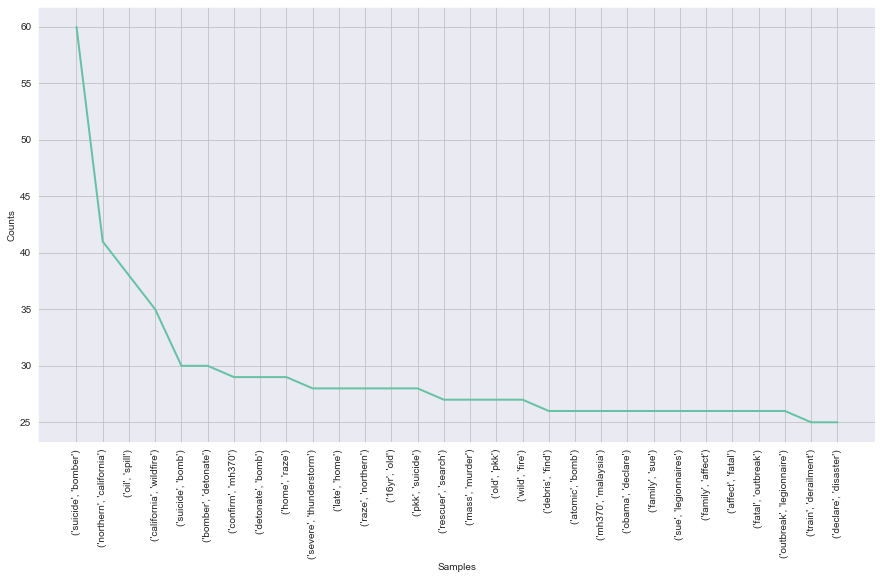

In [47]:
corpus_nostopwords = create_corpus(1, 'preprocessed_text')
bigrams1 = list(nltk.ngrams(corpus_preprocessed1, 2))

bigramsfreqs1 = FreqDist(bigrams1)
for words, count in bigramsfreqs1.most_common(5):
    print(count, " ".join(list(words)))
    
plt.figure(figsize=(15,8))
bigramsfreqs1.plot(30,cumulative=False)
plt.show()

In [48]:
corpus_bigram = []
for i in range(len(bigrams1)):
    corpus_bigram.append(bigrams1[i][0]+'_'+bigrams1[i][1])
corpus_bigram1 = ' '.join(word for word in corpus_bigram)

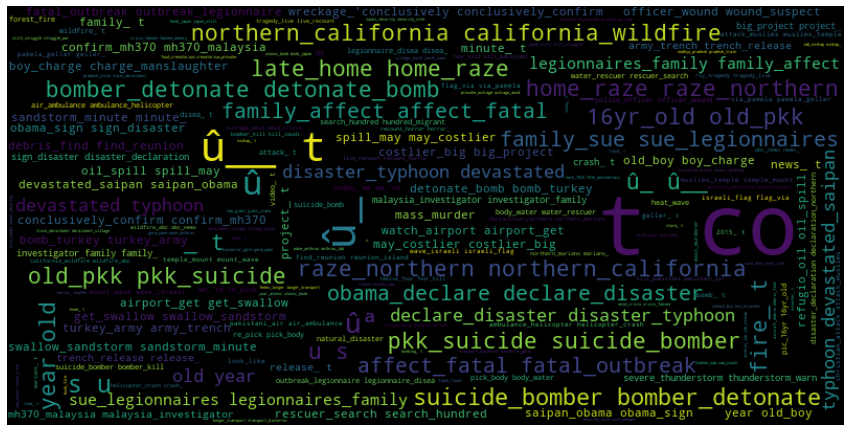

<Figure size 432x288 with 0 Axes>

In [49]:
generatewordcloud(corpus= corpus_bigram1,types='generate', cmap= 'viridis')

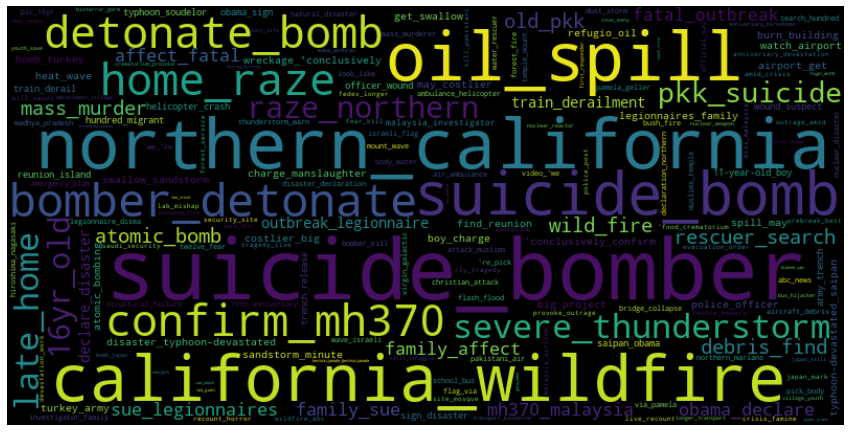

<Figure size 432x288 with 0 Axes>

In [50]:
corpus_bigram_freq1= FreqDist(corpus_bigram)
generatewordcloud(corpus= corpus_bigram_freq1,types='fit_words', cmap= 'viridis')

35 like youtube video
21 cross body bag
18 quarantine offensive content
16 reddit quarantine offensive
16 reddit new content


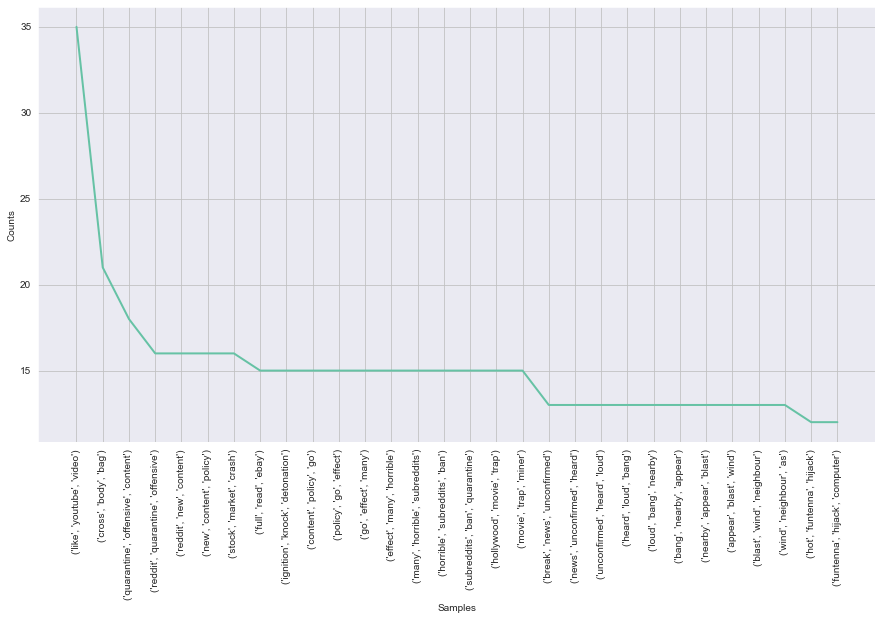

In [51]:
corpus_nostopwords = create_corpus(0, 'preprocessed_text')
trigrams0 = list(nltk.ngrams(corpus_preprocessed0, 3))

trigramsfreqs = FreqDist(trigrams0)
for words, count in trigramsfreqs.most_common(5):
    print(count, " ".join(list(words)))
    
plt.figure(figsize=(15,8))
trigramsfreqs.plot(30,cumulative=False)
plt.show()

In [52]:
corpus_trigram = []
for i in range(len(trigrams0)):
    corpus_trigram.append(trigrams0[i][0]+'_'+trigrams0[i][1]+'_'+trigrams0[i][2])
corpus_trigram0 = ' '.join(word for word in corpus_trigram)

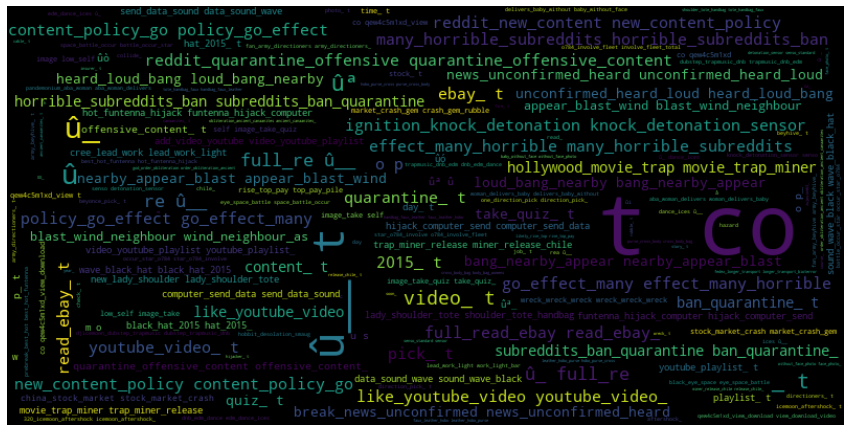

<Figure size 432x288 with 0 Axes>

In [53]:
generatewordcloud(corpus= corpus_trigram0,types='generate', cmap= 'viridis')

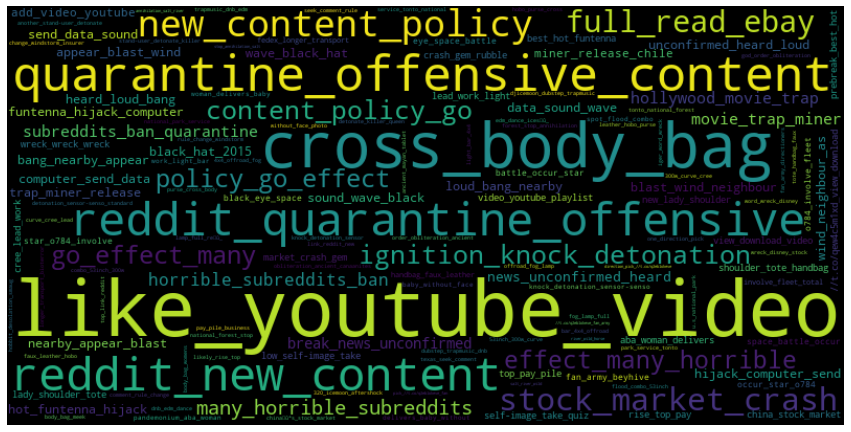

<Figure size 432x288 with 0 Axes>

In [54]:
corpus_trigram_freq0= FreqDist(corpus_trigram)
generatewordcloud(corpus= corpus_trigram_freq0,types='fit_words', cmap= 'viridis')

30 suicide bomber detonate
29 northern california wildfire
28 late home raze
28 home raze northern
28 pkk suicide bomber


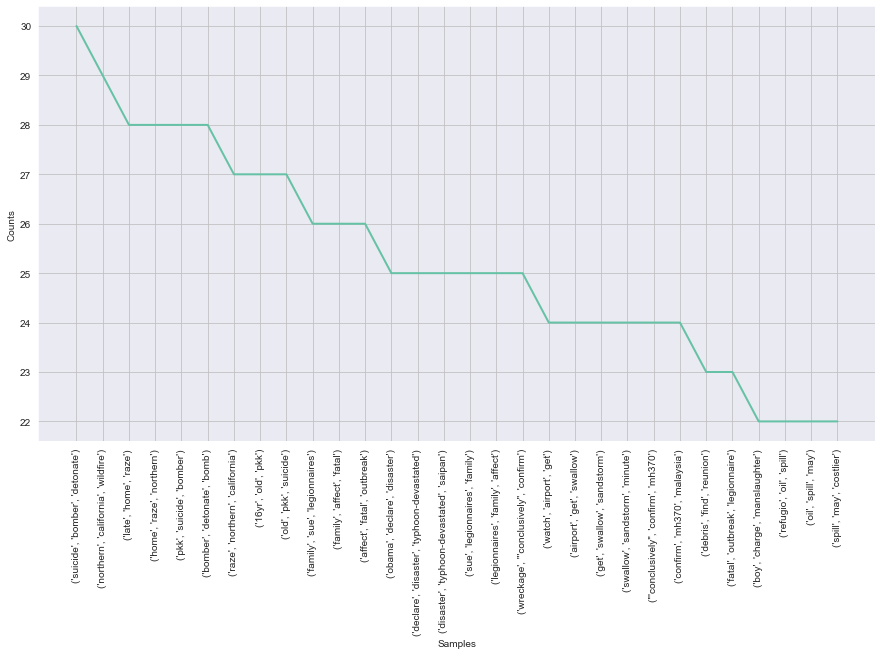

In [55]:
corpus_nostopwords = create_corpus(1, 'preprocessed_text')
trigrams1 = list(nltk.ngrams(corpus_preprocessed1, 3))

trigramsfreqs = FreqDist(trigrams1)
for words, count in trigramsfreqs.most_common(5):
    print(count, " ".join(list(words)))
    
plt.figure(figsize=(15,8))
trigramsfreqs.plot(30,cumulative=False)
plt.show()

In [56]:
corpus_trigram = []
for i in range(len(trigrams1)):
    corpus_trigram.append(trigrams1[i][0]+'_'+trigrams1[i][1]+'_'+trigrams1[i][2])
corpus_trigram1 = ' '.join(word for word in corpus_trigram)

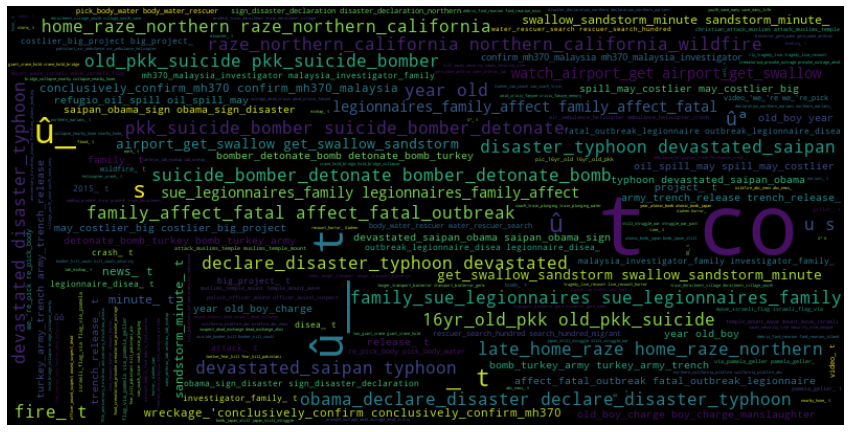

<Figure size 432x288 with 0 Axes>

In [57]:
generatewordcloud(corpus= corpus_trigram1,types='generate', cmap= 'viridis')

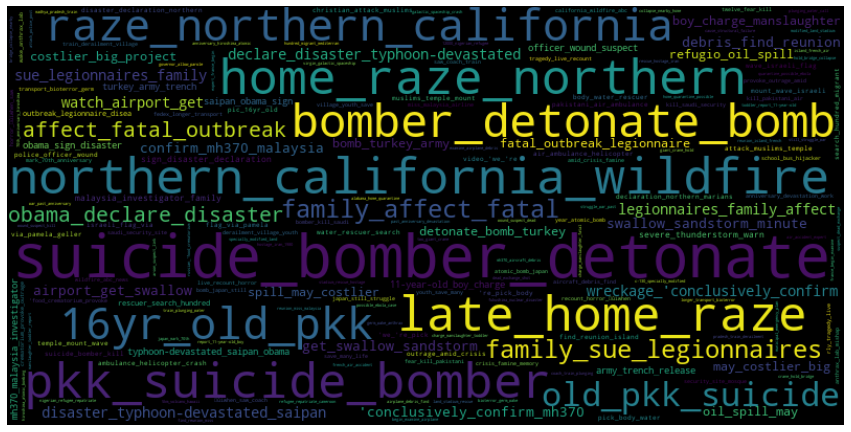

<Figure size 432x288 with 0 Axes>

In [58]:
corpus_trigram_freq1= FreqDist(corpus_trigram)
generatewordcloud(corpus= corpus_trigram_freq1,types='fit_words', cmap= 'viridis')

## Splitting Data

In [59]:
dataset = df_train[['filtered_lemmatize', 'target']]
dataset

filtered_lemmatize  target
0       [deed, reason, earthquake, may, allah, forgive]       1
1             [forest, fire, near, ronge, sask, canada]       1
2     [resident, ask, 'shelter, place, notify, offic...       1
3     [13,000, people, receive, wildfire, evacuation...       1
4     [get, sent, photo, ruby, alaska, smoke, wildfi...       1
...                                                 ...     ...
7608  [two, giant, crane, hold, bridge, collapse, ne...       1
7609  [aria_ahrary, thetawniest, control, wild, fire...       1
7610  [m1.94, 01:04, utc, 5km, volcano, hawaii, //t....       1
7611  [police, investigate, e-bike, collide, car, li...       1
7612  [late, home, raze, northern, california, wildf...       1

[7613 rows x 2 columns]

In [60]:
def List_string(lists):
    return " ".join(lists)
dataset['text'] = dataset['filtered_lemmatize'].apply(List_string)
dataset.head()

filtered_lemmatize  target  \
0    [deed, reason, earthquake, may, allah, forgive]       1   
1          [forest, fire, near, ronge, sask, canada]       1   
2  [resident, ask, 'shelter, place, notify, offic...       1   
3  [13,000, people, receive, wildfire, evacuation...       1   
4  [get, sent, photo, ruby, alaska, smoke, wildfi...       1   

                                                text  
0           deed reason earthquake may allah forgive  
1                 forest fire near ronge sask canada  
2  resident ask 'shelter place notify officer eva...  
3  13,000 people receive wildfire evacuation orde...  
4  get sent photo ruby alaska smoke wildfires pou...

In [61]:
X = dataset.text
y = dataset.target

In [62]:
# Splitting into training & test subsets
from sklearn.model_selection import train_test_split
folds = 5
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = (1/folds), random_state = 20, stratify=y)

In [63]:
print("Train set has total {0} entries with {1:.2f}% not a disaster, {2:.2f}% disaster".format(len(X_train),(len(X_train[y_train == 0]) / (len(X_train)*1.))*100,(len(X_train[y_train == 1]) / (len(X_train)*1.))*100))

print("Validation set has total {0} entries with {1:.2f}% not a disaster, {2:.2f}% disaster".format(len(X_validation),
                                                                             (len(X_validation[y_validation == 0]) / (len(X_validation)*1.))*100,
                                                                            (len(X_validation[y_validation == 1]) / (len(X_validation)*1.))*100))

Train set has total 6090 entries with 57.03% not a disaster, 42.97% disaster
Validation set has total 1523 entries with 57.06% not a disaster, 42.94% disaster


## Feature Extraction

I will start my feature extraction with one of the most basic methods to obtain a numerical representation of our text data. This method is known as the bag-of-words approach, where a corpus of our text data is generated. Than, a numerical representation as a vector is created for each document or text data entry based on the words in the corpus. 

#### Method 1: Count Vectorizer 
Count Vectorizer is a method that creates a value for each element in a document relative to the entire corpus. You can imagine this method can get out of hand once we start analyzing large text dataset. For computational purposes this method is very limited and too costly. In our example here we can afford to use this method with out restricting it with limits once the data has been cleaned and preprocessed. 

Lets look at an example of a corpus consisted of two documents
 - doc1 = 'I am sleepy but awake'
 - doc2 = 'You are sleepy'
 - Corpus = 'I am sleepy but awake You are sleepy'
 
 |    |  I  |  am  |  sleepy  |  but  |  awake  |  You  |  are  |
 |----|-----|------|----------|-------|---------|-------|-------|
 |doc1|  1  |   1  |     2    |   1   |    1    |       |       |
 |doc2|     |      |     1    |       |         |   1   |   1   |
 
 As examined during my EDA phase I will continue with this prepocessed text and try to find the best number of features by using a logistic regression. 

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [65]:
def accurracy_summary(pipeline, X_train, y_train, X_test, y_test):
    percent_of_0 = len(X_test[y_test == 0])/(len(X_test)*1.) # percent of not a disaster for test sample
    if percent_of_0 > 0.5:
        null_accuracy = percent_of_0
    else:
        null_accuracy = 1. - percent_of_0
        
    t0 = time()
    disaster_fit = pipeline.fit(X_train, y_train)
    y_pred = disaster_fit.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_pred, y_test)
    print('null accuracy: {0: .2f}%'.format(null_accuracy*100))
    print('accuracy score: {0: .2f}%'.format(accuracy*100))
    
    if accuracy > null_accuracy:
          print("The model is {0: .2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy ==  null_accuracy:
          print("The model has the same accuracy as the null accuracy")
    else:
          print("The model is {0: .2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
          
    print("train and test time: {0: .2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

In [66]:
cvect = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(1000,10001,1000)

def nfeature_accuracy_checker(vectorizer=cvect, n_features=n_features, ngram_range=(1,1), classifier=lr):
    result=[]
    print(classifier)
    print('\n')
    
    for n in n_features:
        vectorizer.set_params(max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
                                    ('vectorizer', vectorizer),
                                    ('classifier', classifier)
        ])
        print("Validation results for {} features".format(n))
        nfeature_accuracy, tt_time = accurracy_summary(checker_pipeline, X_train, y_train, X_validation, y_validation)
        result.append((n, nfeature_accuracy, tt_time))
    
    return result

In [67]:
%%time
print("Results for unigram with preprocessed text")
feature_results_uni = nfeature_accuracy_checker()

Results for unigram with preprocessed text
LogisticRegression()


Validation results for 1000 features
null accuracy:  57.06%
accuracy score:  78.33%
The model is  21.27% more accurate than null accuracy
train and test time:  0.18s
--------------------------------------------------------------------------------
Validation results for 2000 features
null accuracy:  57.06%
accuracy score:  78.46%
The model is  21.41% more accurate than null accuracy
train and test time:  0.17s
--------------------------------------------------------------------------------
Validation results for 3000 features
null accuracy:  57.06%
accuracy score:  79.05%
The model is  22.00% more accurate than null accuracy
train and test time:  0.17s
--------------------------------------------------------------------------------
Validation results for 4000 features
null accuracy:  57.06%
accuracy score:  79.05%
The model is  22.00% more accurate than null accuracy
train and test time:  0.18s
---------------------------

In [68]:
%%time
print("Results for bigram with preprocessed text")
feature_results_bi = nfeature_accuracy_checker(ngram_range=(1,2))

Results for bigram with preprocessed text
LogisticRegression()


Validation results for 1000 features
null accuracy:  57.06%
accuracy score:  77.74%
The model is  20.68% more accurate than null accuracy
train and test time:  0.31s
--------------------------------------------------------------------------------
Validation results for 2000 features
null accuracy:  57.06%
accuracy score:  78.86%
The model is  21.80% more accurate than null accuracy
train and test time:  0.31s
--------------------------------------------------------------------------------
Validation results for 3000 features
null accuracy:  57.06%
accuracy score:  78.92%
The model is  21.86% more accurate than null accuracy
train and test time:  0.31s
--------------------------------------------------------------------------------
Validation results for 4000 features
null accuracy:  57.06%
accuracy score:  79.25%
The model is  22.19% more accurate than null accuracy
train and test time:  0.35s
----------------------------

In [69]:
%%time
print("Results for Trigram with preprocessed text")
feature_results_tri = nfeature_accuracy_checker(ngram_range=(1,3))

Results for Trigram with preprocessed text
LogisticRegression()


Validation results for 1000 features
null accuracy:  57.06%
accuracy score:  77.54%
The model is  20.49% more accurate than null accuracy
train and test time:  0.48s
--------------------------------------------------------------------------------
Validation results for 2000 features
null accuracy:  57.06%
accuracy score:  78.14%
The model is  21.08% more accurate than null accuracy
train and test time:  0.44s
--------------------------------------------------------------------------------
Validation results for 3000 features
null accuracy:  57.06%
accuracy score:  78.99%
The model is  21.93% more accurate than null accuracy
train and test time:  0.47s
--------------------------------------------------------------------------------
Validation results for 4000 features
null accuracy:  57.06%
accuracy score:  79.19%
The model is  22.13% more accurate than null accuracy
train and test time:  0.46s
---------------------------

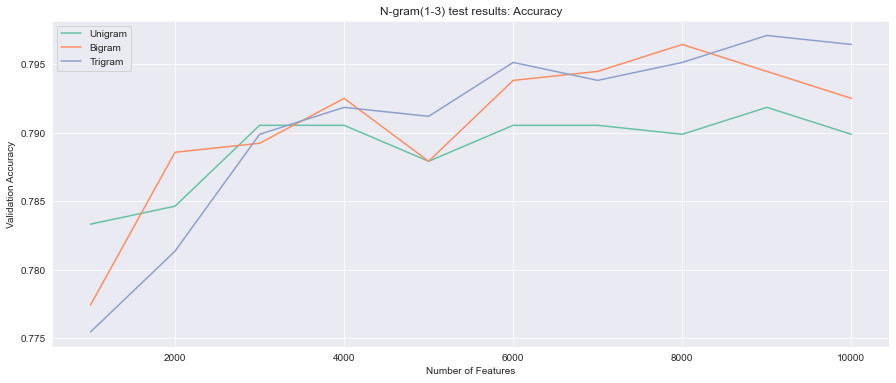

In [70]:
nfeatures_plot_uni = pd.DataFrame(feature_results_uni, columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bi = pd.DataFrame(feature_results_bi, columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tri = pd.DataFrame(feature_results_tri, columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(15,6))
plt.plot(nfeatures_plot_uni.nfeatures, nfeatures_plot_uni.validation_accuracy, label='Unigram')
plt.plot(nfeatures_plot_bi.nfeatures, nfeatures_plot_bi.validation_accuracy, label='Bigram')
plt.plot(nfeatures_plot_tri.nfeatures, nfeatures_plot_tri.validation_accuracy, label='Trigram')
plt.title('N-gram(1-3) test results: Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy')
plt.legend()

The best number of features to achieve optimal validation accuracy for each n-gram is listed below:
- Unigram : 9000 features at validation accuracy 79.19%
- Bigram : 8000 features at validation accuracy 79.65%
- Trigram : 9000 features at validation accuracy 79.71%

In [71]:
def train_test_and_evaluate(pipeline, X_train, y_train, X_test, y_test):
    percent_of_0 = len(X_test[y_test == 0])/(len(X_test)*1.) # percent of not a disaster for test sample
    if percent_of_0 > 0.5:
        null_accuracy = percent_of_0
    else:
        null_accuracy = 1. - percent_of_0
    
    cv = model_selection.KFold(n_splits=(folds - 1), shuffle=True, random_state=20)
    scores = model_selection.cross_validate(pipeline, X_train, y_train, cv = cv)
    
    disaster_fit = pipeline.fit(X_train, y_train)
    y_pred = disaster_fit.predict(X_test)
    accuracy = accuracy_score(y_pred, y_test)
    
    cm = confusion_matrix(y_test, y_pred) 
    cm_df = pd.DataFrame(cm, index=['Not_Disaster', 'Disaster'], columns=['Not_Disaster','Disaster'])
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=labels, fmt='')

    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
        
    print(scores)    
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['Not Disaster','Disaster']))
    print("-"*80)
    print("Confusion Matrix\n")
    plt.title('Logistic Classifier:CV \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

null accuracy: 57.06%
accuracy score: 79.05%
model is 22.00% more accurate than null accuracy
{'fit_time': array([0.13342738, 0.15719843, 0.14178157, 0.1427319 ]), 'score_time': array([0.01614881, 0.01561189, 0.03154182, 0.01561093]), 'test_score': array([0.80105056, 0.78463559, 0.79500657, 0.80814717])}
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

Not Disaster       0.79      0.87      0.83       869
    Disaster       0.80      0.69      0.74       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

--------------------------------------------------------------------------------
Confusion Matrix



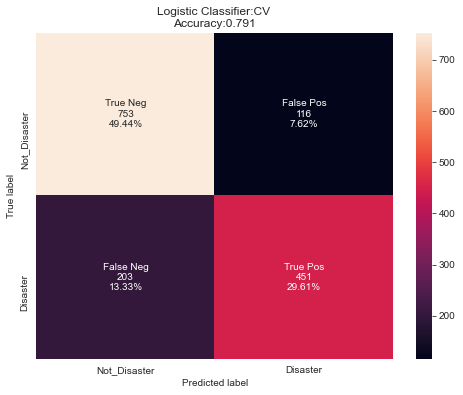

Wall time: 1.05 s


In [72]:
%%time
ug_cvec = CountVectorizer(max_features=6000)
ug_pipeline = Pipeline([
        ('vectorizer', ug_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(ug_pipeline, X_train, y_train, X_validation, y_validation)

null accuracy: 57.06%
accuracy score: 79.45%
model is 22.39% more accurate than null accuracy
{'fit_time': array([0.2690568 , 0.26716685, 0.254565  , 0.28802752]), 'score_time': array([0.03142762, 0.04754972, 0.03145814, 0.03124428]), 'test_score': array([0.80302035, 0.78069599, 0.79763469, 0.80814717])}
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

Not Disaster       0.79      0.87      0.83       869
    Disaster       0.81      0.69      0.74       654

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.79      0.79      1523

--------------------------------------------------------------------------------
Confusion Matrix



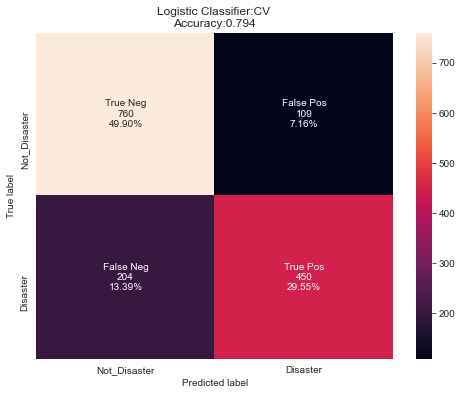

Wall time: 1.77 s


In [73]:
%%time
bg_cvec = CountVectorizer(max_features=9000, ngram_range=(1, 2))
bg_pipeline = Pipeline([
        ('vectorizer', bg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(bg_pipeline, X_train, y_train, X_validation, y_validation)

null accuracy: 57.06%
accuracy score: 79.71%
model is 22.65% more accurate than null accuracy
{'fit_time': array([0.37008667, 0.36248589, 0.37855506, 0.36736226]), 'score_time': array([0.04706383, 0.03137684, 0.03138208, 0.04690361]), 'test_score': array([0.80564675, 0.777413  , 0.79500657, 0.80814717])}
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

Not Disaster       0.79      0.88      0.83       869
    Disaster       0.81      0.69      0.74       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523

--------------------------------------------------------------------------------
Confusion Matrix



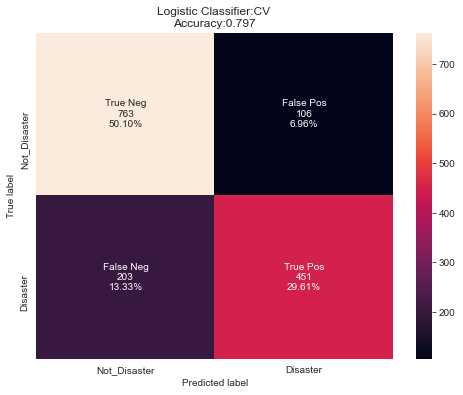

Wall time: 2.37 s


In [74]:
%%time
tg_cvec = CountVectorizer(max_features=9000, ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, X_train, y_train, X_validation, y_validation)

In [75]:
%%time
tvec = TfidfVectorizer()
print("Results for unigram with preprocessed text using TFIDF")
feature_results_tfidf_uni = nfeature_accuracy_checker(vectorizer=tvec);
feature_results_tfidf_bi = nfeature_accuracy_checker(vectorizer=tvec, ngram_range=(1, 2));
feature_results_tfidf_tri = nfeature_accuracy_checker(vectorizer=tvec, ngram_range=(1, 3));

nfeatures_plot_tfidf_uni = pd.DataFrame(feature_results_tfidf_uni, columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tfidf_bi = pd.DataFrame(feature_results_tfidf_bi, columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tfidf_tri = pd.DataFrame(feature_results_tfidf_tri, columns=['nfeatures','validation_accuracy','train_test_time'])

Results for unigram with preprocessed text using TFIDF
LogisticRegression()


Validation results for 1000 features
null accuracy:  57.06%
accuracy score:  78.46%
The model is  21.41% more accurate than null accuracy
train and test time:  0.16s
--------------------------------------------------------------------------------
Validation results for 2000 features
null accuracy:  57.06%
accuracy score:  78.86%
The model is  21.80% more accurate than null accuracy
train and test time:  0.15s
--------------------------------------------------------------------------------
Validation results for 3000 features
null accuracy:  57.06%
accuracy score:  79.25%
The model is  22.19% more accurate than null accuracy
train and test time:  0.15s
--------------------------------------------------------------------------------
Validation results for 4000 features
null accuracy:  57.06%
accuracy score:  79.51%
The model is  22.46% more accurate than null accuracy
train and test time:  0.15s
---------------

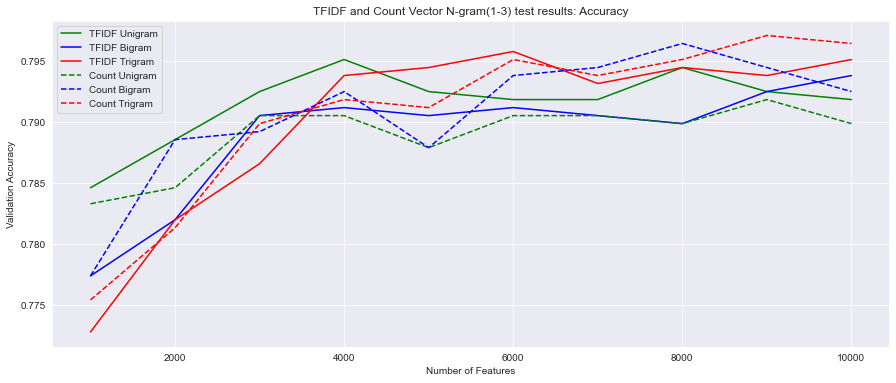

In [76]:
plt.figure(figsize=(15,6))
plt.plot(nfeatures_plot_tfidf_uni.nfeatures, nfeatures_plot_tfidf_uni.validation_accuracy, ls='-', color='g', label='TFIDF Unigram')
plt.plot(nfeatures_plot_tfidf_bi.nfeatures, nfeatures_plot_tfidf_bi.validation_accuracy, ls='-', color='b', label='TFIDF Bigram')
plt.plot(nfeatures_plot_tfidf_tri.nfeatures, nfeatures_plot_tfidf_tri.validation_accuracy, ls='-', color='r', label='TFIDF Trigram')

plt.plot(nfeatures_plot_uni.nfeatures, nfeatures_plot_uni.validation_accuracy, ls='--', color='g', label='Count Unigram')
plt.plot(nfeatures_plot_bi.nfeatures, nfeatures_plot_bi.validation_accuracy, ls='--', color='b', label='Count Bigram')
plt.plot(nfeatures_plot_tri.nfeatures, nfeatures_plot_tri.validation_accuracy,  ls='--', color='r', label='Count Trigram')

plt.title('TFIDF and Count Vector N-gram(1-3) test results: Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy')
plt.legend()

In [77]:
## TFIDF Unigram 4000 79.51%
## TFIDF Bigram 10000 79.38%
## TFIDF Trigram 6000 79.58%

In [78]:
def train_test_and_evaluate_clf(pipeline, X_train, y_train, X_test, y_test):    
    t0 = time()
    disaster_fit = pipeline.fit(X_train, y_train)
    y_pred = disaster_fit.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

          
    return recall, accuracy, train_test_time

In [93]:
def disaster_classifier_compare(vectorizer, n_features, ngram, classifier, types):
    results = []
    vectorizer.set_params(max_features=n_features, ngram_range=ngram)
    for name,clf in classifier:
        classifier_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', clf)
        ])
        ngram_type = types
        clf_recall, clf_accuracy, time_tt = train_test_and_evaluate_clf(classifier_pipeline, X_train, y_train, X_validation, y_validation)
        results.append((name, clf_accuracy, clf_recall, time_tt, ngram_type))
    result_df = pd.DataFrame(results, columns=['name','validation_accuracy','validation_recall','train_test_time', 'ngram_type'])
    result_df.sort_values(by='validation_recall', ascending=False, inplace=True)
    result_df = result_df.reset_index(drop=True)
    return result_df

In [94]:
name = ["Logistic Regression", "Decision Tree", "Random Forest", "Ridge Classifier", "XGBoost",
            "KNearest-Neighbor", "Linear SVC", "Multinomial Naive Bayes", "Bernoulli Naive Bayes"]
    
models = [ LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), RidgeClassifier(),
              XGBClassifier(use_label_encoder=False), KNeighborsClassifier(), LinearSVC(), MultinomialNB(), BernoulliNB() ]
    
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()
unigram_results = disaster_classifier_compare(tvec, 4000, (1, 1), zipped_clf, 'unigram')
unigram_results

[18:36:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


name  validation_accuracy  validation_recall  \
0               Linear SVC             0.774787           0.704893   
1         Ridge Classifier             0.783979           0.700306   
2      Logistic Regression             0.795141           0.678899   
3  Multinomial Naive Bayes             0.797111           0.677370   
4    Bernoulli Naive Bayes             0.798424           0.660550   
5            Random Forest             0.780039           0.657492   
6            Decision Tree             0.724228           0.652905   
7                  XGBoost             0.779383           0.636086   
8        KNearest-Neighbor             0.677610           0.347095   

   train_test_time ngram_type  
0         0.109854    unigram  
1         0.110072    unigram  
2         0.166373    unigram  
3         0.110377    unigram  
4         0.093676    unigram  
5         3.475572    unigram  
6         0.654201    unigram  
7         0.870008    unigram  
8         0.348181    unigram

In [95]:
name = ["Logistic Regression", "Decision Tree", "Random Forest", "Ridge Classifier", "XGBoost",
            "KNearest-Neighbor", "Linear SVC", "Multinomial Naive Bayes", "Bernoulli Naive Bayes"]
    
models = [ LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), RidgeClassifier(),
              XGBClassifier(use_label_encoder=False), KNeighborsClassifier(), LinearSVC(), MultinomialNB(), BernoulliNB() ]
    
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()
bigram_results = disaster_classifier_compare(tvec, 10000, (1, 2), zipped_clf, 'bigram')
bigram_results

[18:37:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


name  validation_accuracy  validation_recall  \
0         Ridge Classifier             0.788575           0.700306   
1               Linear SVC             0.782009           0.695719   
2      Logistic Regression             0.793828           0.672783   
3            Decision Tree             0.738017           0.672783   
4                  XGBoost             0.787919           0.651376   
5            Random Forest             0.794485           0.648318   
6  Multinomial Naive Bayes             0.798424           0.637615   
7    Bernoulli Naive Bayes             0.793828           0.585627   
8        KNearest-Neighbor             0.680893           0.295107   

   train_test_time ngram_type  
0         0.251960     bigram  
1         0.265269     bigram  
2         0.376245     bigram  
3         1.144065     bigram  
4         1.463254     bigram  
5         5.069466     bigram  
6         0.235226     bigram  
7         0.265954     bigram  
8         0.492152     bigram

In [96]:
name = ["Logistic Regression", "Decision Tree", "Random Forest", "Ridge Classifier", "XGBoost",
            "KNearest-Neighbor", "Linear SVC", "Multinomial Naive Bayes", "Bernoulli Naive Bayes"]
    
models = [ LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), RidgeClassifier(),
              XGBClassifier(use_label_encoder=False), KNeighborsClassifier(), LinearSVC(), MultinomialNB(), BernoulliNB() ]
    
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()
trigram_results = disaster_classifier_compare(tvec, 6000, (1, 3), zipped_clf, 'trigram')
trigram_results

[18:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


name  validation_accuracy  validation_recall  \
0         Ridge Classifier             0.780696           0.698777   
1               Linear SVC             0.770847           0.698777   
2      Logistic Regression             0.795798           0.685015   
3            Decision Tree             0.723572           0.666667   
4            Random Forest             0.782666           0.655963   
5                  XGBoost             0.779383           0.642202   
6  Multinomial Naive Bayes             0.793171           0.626911   
7    Bernoulli Naive Bayes             0.777413           0.535168   
8        KNearest-Neighbor             0.669074           0.347095   

   train_test_time ngram_type  
0         0.406757    trigram  
1         0.390809    trigram  
2         0.456155    trigram  
3         1.085775    trigram  
4         4.550054    trigram  
5         1.397890    trigram  
6         0.426807    trigram  
7         0.416977    trigram  
8         0.646431    trigram

In [133]:
df_model_results = pd.concat([unigram_results, bigram_results, trigram_results], axis=0)
df_model_results.reset_index(inplace=True, drop=True)

In [135]:
df_model_results.drop([8,17,26], inplace=True)
df_model_results.reset_index(inplace=True, drop=True)

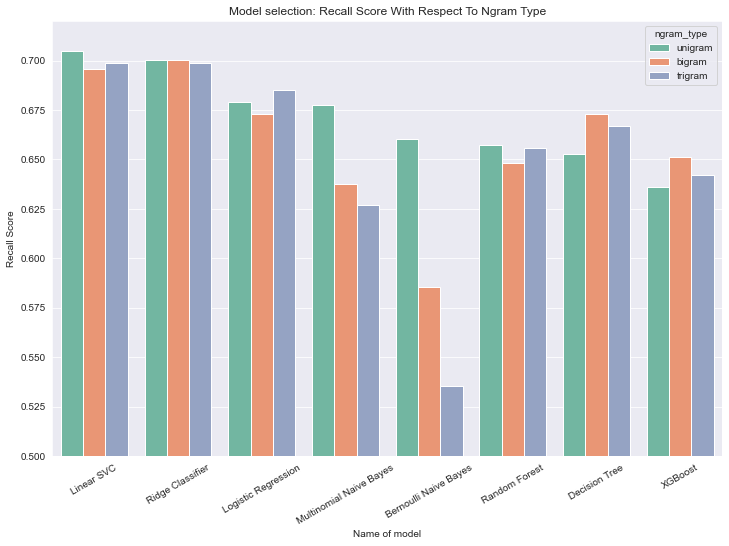

In [136]:
plt.figure(figsize=(12,8))
chart = sns.barplot(data=df_model_results, x="name", y='validation_recall', hue='ngram_type')
chart.set_title('Model selection: Recall Score With Respect To Ngram Type')
chart.set_xlabel('Name of model')
chart.set_ylabel('Recall Score')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30)
chart.set(ylim=(.5,.72))
plt.show()

##### The models I will use to tweek the hyper perameters for TFIDF( Max_features=4000, ngram=(1,1))
1. Linear SVC
2. Ridge Classifier
3. Logistic Regression
4. Multinomial Naive Bayes

In [150]:
def train_test_and_evaluate_clf_GS(pipeline, X_train, y_train, X_test, y_test, grid_params):
    percent_of_0 = len(X_test[y_test == 0])/(len(X_test)*1.) # percent of not a disaster for test sample
    if percent_of_0 > 0.5:
        null_accuracy = percent_of_0
    else:
        null_accuracy = 1. - percent_of_0
    
    cv = model_selection.KFold(n_splits=(folds - 1), shuffle=True, random_state=20)
    scores = model_selection.cross_validate(pipeline, X_train, y_train, cv = cv)
    df_cv = pd.DataFrame(scores)
    
    t0 = time()
    clf = GridSearchCV(pipeline, grid_params, cv = 10, scoring='recall')
    disaster_fit = clf.fit(X_train, y_train)
    y_pred = disaster_fit.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred) 
    cm_df = pd.DataFrame(cm, index=['Not_Disaster', 'Disaster'], columns=['Not_Disaster','Disaster'])
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_df, annot=labels, fmt='')

    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print(green("accuracy score: {0:.2f}%".format(accuracy*100), ['bold']))
    print(blue("recall score: {0:.2f}%".format(recall*100), ['bold']))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    
    print("-"*80)
    print("Cross Validation Results\n")
    print(df_cv.mean())
    print("-"*80)
    print("GridSearchCV Report\n")
    print('GridSearch Parameters: {}\n'.format(grid_params))
    print("Recall score after Gridsearch: {}\n".format(clf.score(X_validation, y_validation)))
    print("Optimal hyperparameters for recall\n")
    print(clf.best_estimator_)      
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['Not Disaster','Disaster']))
    print("-"*80)
    print("Confusion Matrix\n")
    plt.title('Classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print(black("_"*80, ['bold']))
          
    return recall, accuracy, train_test_time

In [151]:
def disaster_classifier_compare_GS(vectorizer, n_features, ngram, classifier, grid_params, types):
    if types == 'off':
        results = []
        vectorizer.set_params(max_features=n_features, ngram_range=ngram)
        for name,clf in classifier:
            classifier_pipeline = Pipeline([
                ('vectorizer', vectorizer),
                ('classifier', clf)
            ])
            print("Validation accuracy for", red("{}".format(name), ['bold', 'underlined']))
            print(clf)
            clf_recall, clf_accuracy, time_tt = train_test_and_evaluate_clf_GS(classifier_pipeline, X_train, y_train, X_validation, y_validation, grid_params)
            results.append((name, clf_accuracy, clf_recall, time_tt))
        result_df = pd.DataFrame(results, columns=['name','validation_accuracy','validation_recall','train_test_time'])
        
    elif types == 'on':
        results = []
        vectorizer.set_params(max_features=n_features, ngram_range=ngram)
        for name,clf in classifier:
            classifier_pipeline = Pipeline([
                ('vectorizer', vectorizer),
                ('ss', StandardScaler(with_mean=False)),
                ('classifier', clf)
            ])
            print("Validation accuracy for", red("{}".format(name), ['bold', 'underlined']))
            print(clf)
            clf_recall, clf_accuracy, time_tt = train_test_and_evaluate_clf_GS(classifier_pipeline, X_train, y_train, X_validation, y_validation, grid_params)
            results.append((name, clf_accuracy, clf_recall, time_tt))
        result_df = pd.DataFrame(results, columns=['name','validation_accuracy','validation_recall','train_test_time'])
    return result_df

In [90]:
### hypertune parameters 
# 1. Linear SVC: Using a linear SVC 
grid_params = {'alpha':[1.0,5.0,10.0,25.0]}
grid_para = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_para = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25],dual : [True,False], solver : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

### Linear SVC GridSearchCV Recall: With and Without Standardization

Validation accuracy for Linear SVC
LinearSVC()
null accuracy: 57.06%
accuracy score: 77.48%
recall score: 70.49%
model is 20.42% more accurate than null accuracy
--------------------------------------------------------------------------------
Cross Validation Results

fit_time      0.089481
score_time    0.017602
test_score    0.778819
dtype: float64
--------------------------------------------------------------------------------
GridSearchCV Report

GridSearch Parameters: {'classifier__penalty': ['l1', 'l2'], 'classifier__loss': ['hinge', 'squared_hinge'], 'classifier__C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25]}

Recall score after Gridsearch: 0.7048929663608563

Optimal hyperparameters for recall

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),
                ('classifier', LinearSVC(C=1))])
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

Not Disaster 

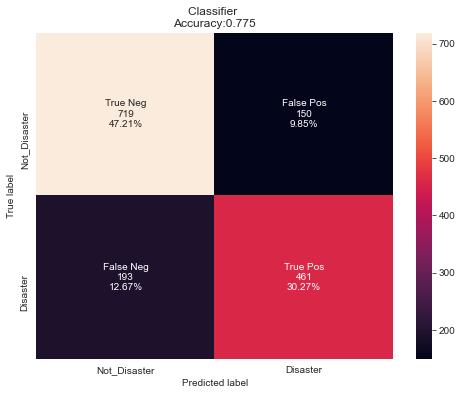

________________________________________________________________________________


name  validation_accuracy  validation_recall  train_test_time
0  Linear SVC             0.774787           0.704893        35.754309

In [155]:
#Without Standardization
name = ["Linear SVC"]    
models = [ LinearSVC()]
grid_params = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__C':[0.001,.009,0.01,.09,1,5,10,25]
}   
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()

disaster_classifier_compare_GS(tvec, 4000, (1, 1), zipped_clf, grid_params, 'off')

Validation accuracy for Linear SVC
LinearSVC()
null accuracy: 57.06%
accuracy score: 75.44%
recall score: 70.03%
model is 18.38% more accurate than null accuracy
--------------------------------------------------------------------------------
Cross Validation Results

fit_time      0.210889
score_time    0.017089
test_score    0.694744
dtype: float64
--------------------------------------------------------------------------------
GridSearchCV Report

GridSearch Parameters: {'classifier__penalty': ['l1', 'l2'], 'classifier__loss': ['hinge', 'squared_hinge'], 'classifier__C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25]}

Recall score after Gridsearch: 0.7003058103975535

Optimal hyperparameters for recall

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),
                ('ss', StandardScaler(with_mean=False)),
                ('classifier', LinearSVC(C=0.001, loss='hinge'))])
--------------------------------------------------------------------------------
Classification R

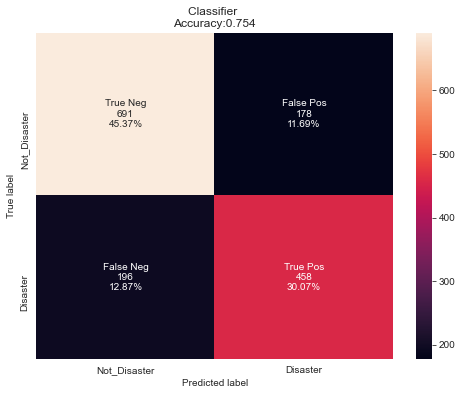

________________________________________________________________________________


name  validation_accuracy  validation_recall  train_test_time
0  Linear SVC             0.754432           0.700306        50.359042

In [156]:
#With Standardization
name = ["Linear SVC"]    
models = [ LinearSVC()]
grid_params = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__C':[0.001,.009,0.01,.09,1,5,10,25]
}   
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()

disaster_classifier_compare_GS(tvec, 4000, (1, 1), zipped_clf, grid_params, 'on')

### Ridge Classifier GridSearchCV Recall: With and Without Standardization

Validation accuracy for Ridge Classifier
RidgeClassifier()
null accuracy: 57.06%
accuracy score: 78.40%
recall score: 70.03%
model is 21.34% more accurate than null accuracy
--------------------------------------------------------------------------------
Cross Validation Results

fit_time      0.164301
score_time    0.035634
test_score    0.789657
dtype: float64
--------------------------------------------------------------------------------
GridSearchCV Report

GridSearch Parameters: {'classifier__alpha': (1.0, 5.0, 10.0, 25.0), 'classifier__normalize': [False, True]}

Recall score after Gridsearch: 0.7003058103975535

Optimal hyperparameters for recall

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),
                ('classifier', RidgeClassifier())])
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

Not Disaster       0.79      0.85      0.82       869
   

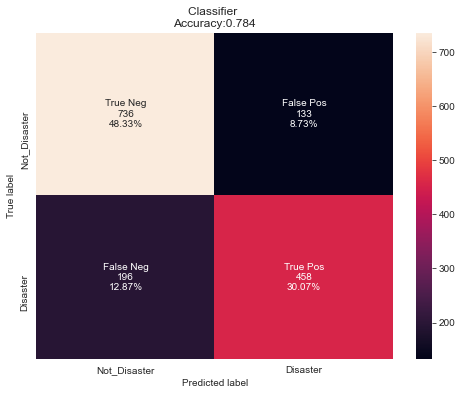

________________________________________________________________________________


name  validation_accuracy  validation_recall  train_test_time
0  Ridge Classifier             0.783979           0.700306        17.529112

In [152]:
#Without Standardization
name = ["Ridge Classifier"]    
models = [ RidgeClassifier()]
grid_params = {
    'classifier__alpha': (1.0,5.0,10.0,25.0),
    'classifier__normalize': [False, True]
}   
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()

disaster_classifier_compare_GS(tvec, 4000, (1, 1), zipped_clf, grid_params, 'off')

Validation accuracy for Ridge Classifier
RidgeClassifier()
null accuracy: 57.06%
accuracy score: 77.74%
recall score: 66.51%
model is 20.68% more accurate than null accuracy
--------------------------------------------------------------------------------
Cross Validation Results

fit_time      0.295785
score_time    0.037101
test_score    0.642037
dtype: float64
--------------------------------------------------------------------------------
GridSearchCV Report

GridSearch Parameters: {'classifier__alpha': (1.0, 5.0, 10.0, 25.0), 'classifier__normalize': [False, True]}

Recall score after Gridsearch: 0.6651376146788991

Optimal hyperparameters for recall

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),
                ('ss', StandardScaler(with_mean=False)),
                ('classifier', RidgeClassifier(normalize=True))])
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-sco

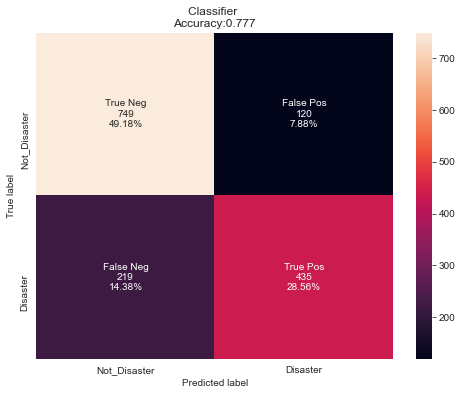

________________________________________________________________________________


name  validation_accuracy  validation_recall  train_test_time
0  Ridge Classifier             0.777413           0.665138        19.548042

In [153]:
#With Standardization
name = ["Ridge Classifier"]    
models = [ RidgeClassifier()]
grid_params = {
    'classifier__alpha': (1.0,5.0,10.0,25.0),
    'classifier__normalize': [False, True]
}  
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()

disaster_classifier_compare_GS(tvec, 4000, (1, 1), zipped_clf, grid_params, 'on')

### Logistic Regression GridSearchCV Recall: With and Without Standardization

Validation accuracy for Logistic Regression
LogisticRegression()
null accuracy: 57.06%
accuracy score: 76.95%
recall score: 71.41%
model is 19.89% more accurate than null accuracy
--------------------------------------------------------------------------------
Cross Validation Results

fit_time      0.146939
score_time    0.024072
test_score    0.798195
dtype: float64
--------------------------------------------------------------------------------
GridSearchCV Report

GridSearch Parameters: {'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25], 'classifier__dual': [True, False], 'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

Recall score after Gridsearch: 0.7140672782874617

Optimal hyperparameters for recall

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),
                ('classifier',
                 LogisticRegression(C=25, dual=True, solver='liblinear'))])
-----------------------------------

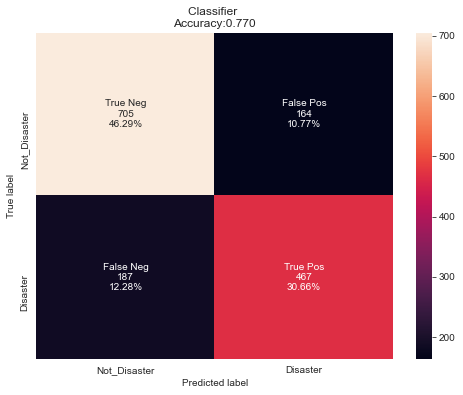

________________________________________________________________________________


name  validation_accuracy  validation_recall  \
0  Logistic Regression             0.769534           0.714067   

   train_test_time  
0       363.108854

In [157]:
#Without Standardization
name = ["Logistic Regression"]    
models = [ LogisticRegression()]
grid_params = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C':[0.001,.009,0.01,.09,1,5,10,25],
    'classifier__dual' : [True,False],
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}   
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()

disaster_classifier_compare_GS(tvec, 4000, (1, 1), zipped_clf, grid_params, 'off')

Validation accuracy for Logistic Regression
LogisticRegression()
null accuracy: 57.06%
accuracy score: 75.84%
recall score: 71.56%
model is 18.78% more accurate than null accuracy
--------------------------------------------------------------------------------
Cross Validation Results

fit_time      0.166134
score_time    0.018300
test_score    0.716255
dtype: float64
--------------------------------------------------------------------------------
GridSearchCV Report

GridSearch Parameters: {'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25], 'classifier__dual': [True, False], 'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

Recall score after Gridsearch: 0.7155963302752294

Optimal hyperparameters for recall

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),
                ('ss', StandardScaler(with_mean=False)),
                ('classifier',
                 LogisticRegression(C=0.09, penalty='l

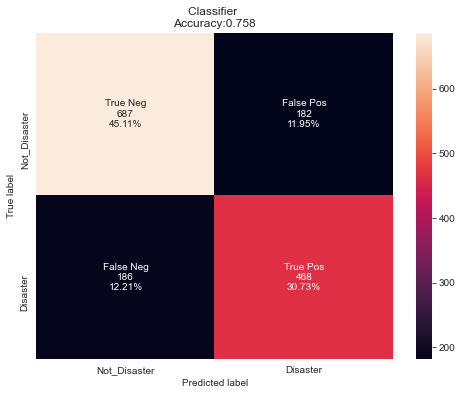

________________________________________________________________________________


name  validation_accuracy  validation_recall  \
0  Logistic Regression             0.758372           0.715596   

   train_test_time  
0       675.103436

In [158]:
#With Standardization
name = ["Logistic Regression"]    
models = [ LogisticRegression()]
grid_params = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C':[0.001,.009,0.01,.09,1,5,10,25],
    'classifier__dual' : [True,False],
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}   
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()

disaster_classifier_compare_GS(tvec, 4000, (1, 1), zipped_clf, grid_params, 'on')

### Multinomial Naive Bayes GridSearchCV Recall: With and Without Standardization

Validation accuracy for Multinomial Naive Bayes
MultinomialNB()
null accuracy: 57.06%
accuracy score: 78.53%
recall score: 67.89%
model is 21.47% more accurate than null accuracy
--------------------------------------------------------------------------------
Cross Validation Results

fit_time      0.080770
score_time    0.018542
test_score    0.801312
dtype: float64
--------------------------------------------------------------------------------
GridSearchCV Report

GridSearch Parameters: {'classifier__alpha': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25]}

Recall score after Gridsearch: 0.6788990825688074

Optimal hyperparameters for recall

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),
                ('classifier', MultinomialNB(alpha=0.09))])
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

Not Disaster       0.78      0.87      0.82       869
    Disaster

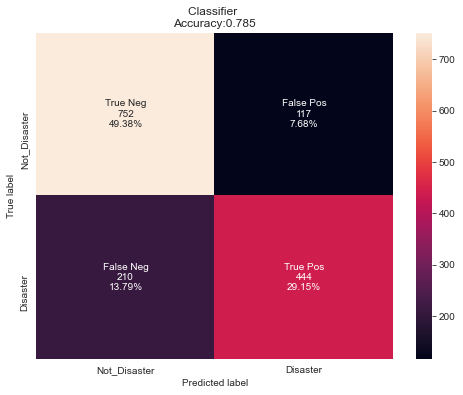

________________________________________________________________________________


name  validation_accuracy  validation_recall  \
0  Multinomial Naive Bayes             0.785292           0.678899   

   train_test_time  
0         7.828703

In [159]:
#Without Standardization
name = ["Multinomial Naive Bayes"]    
models = [ MultinomialNB()]
grid_params = {
    'classifier__alpha':[0.001,.009,0.01,.09,1,5,10,25],
}   
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()

disaster_classifier_compare_GS(tvec, 4000, (1, 1), zipped_clf, grid_params, 'off')

Validation accuracy for Multinomial Naive Bayes
MultinomialNB()
null accuracy: 57.06%
accuracy score: 76.43%
recall score: 71.56%
model is 19.37% more accurate than null accuracy
--------------------------------------------------------------------------------
Cross Validation Results

fit_time      0.081743
score_time    0.018982
test_score    0.758129
dtype: float64
--------------------------------------------------------------------------------
GridSearchCV Report

GridSearch Parameters: {'classifier__alpha': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25]}

Recall score after Gridsearch: 0.7155963302752294

Optimal hyperparameters for recall

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),
                ('ss', StandardScaler(with_mean=False)),
                ('classifier', MultinomialNB(alpha=25))])
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

Not Disaste

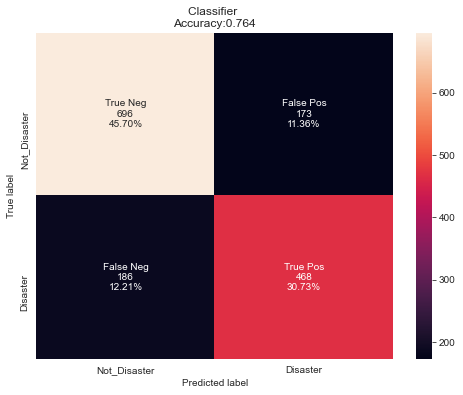

________________________________________________________________________________


name  validation_accuracy  validation_recall  \
0  Multinomial Naive Bayes             0.764281           0.715596   

   train_test_time  
0         8.355437

In [160]:
#With Standardization
name = ["Multinomial Naive Bayes"]    
models = [ MultinomialNB()]
grid_params = {
    'classifier__alpha':[0.001,.009,0.01,.09,1,5,10,25],
}   
zipped_clf = zip(name, models)
tvec= TfidfVectorizer()

disaster_classifier_compare_GS(tvec, 4000, (1, 1), zipped_clf, grid_params, 'on')

## Voting Classifier : Hard Vote

#### With out Standardize
##### LinearSVC
accuracy score: 77.48%\
recall score: 70.49%\
Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),\
                ('classifier', LinearSVC(C=1))])
##### RidgeClassifier
accuracy score: 78.40%\
recall score: 70.03%\
Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),\
                ('classifier', RidgeClassifier())])

##### LogisticRegression
accuracy score: 76.95%\
recall score: 71.41%\
Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),\
                ('classifier', LogisticRegression(C=25, dual=True, solver='liblinear'))])

Hard Voting Score 77.54432042022324 %
Hard Voting Recall 70.64220183486239 %
Classification Report

              precision    recall  f1-score   support

Not Disaster       0.79      0.83      0.81       869
    Disaster       0.75      0.71      0.73       654

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.78      0.77      1523

--------------------------------------------------------------------------------
Confusion Matrix



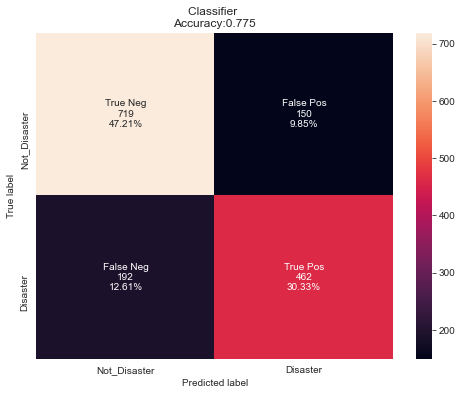

________________________________________________________________________________


In [161]:
# group / ensemble of models
clf1 = LinearSVC(C=1)
clf2 = RidgeClassifier()
clf3 = LogisticRegression(C=25, dual=True, solver='liblinear')

ehclf = VotingClassifier(estimators = [('LSVC', clf1), ('RGC', clf2), ('LR', clf3)], voting ='hard')

# Voting Classifier with hard voting
classifier_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=4000)),
    ('classifier', ehclf)
])
classifier_pipeline.fit(X_train, y_train)
y_pred = classifier_pipeline.predict(X_validation)
  
# using accuracy_score metric to predict accuracy
score = accuracy_score(y_validation.values, y_pred)
recall = recall_score(y_validation.values, y_pred)
print("Hard Voting Score", score*100,'%')
print("Hard Voting Recall", recall*100,'%')

cm = confusion_matrix(y_validation.values, y_pred) 
cm_df = pd.DataFrame(cm, index=['Not_Disaster', 'Disaster'], columns=['Not_Disaster','Disaster'])
    
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Classification Report\n")
print(classification_report(y_validation.values, y_pred, target_names=['Not Disaster','Disaster']))
print("-"*80)
print("Confusion Matrix\n")
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=labels, fmt='')
plt.title('Classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_validation.values, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(black("_"*80, ['bold']))

In [157]:
# Can't perform a soft vote. AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

#### With Standardize
##### LinearSVC
accuracy score: 75.44%\
recall score: 70.03%\
Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),\
                ('ss', StandardScaler(with_mean=False)),\
                ('classifier', LinearSVC(C=0.001, loss='hinge'))])
##### LogisticRegression
accuracy score: 75.84%\
recall score: 71.56%\
Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),\
                ('ss', StandardScaler(with_mean=False)),\
                ('classifier',LogisticRegression(C=0.09, penalty='l1', solver='saga'))])

##### MultinumialNB
accuracy score: 76.43%\
recall score: 71.56%\
Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=4000)),\
                ('ss', StandardScaler(with_mean=False)),\
                ('classifier', MultinomialNB(alpha=25))])

Hard Voting Score 75.7715036112935 %
Hard Voting Recall 70.64220183486239 %
Classification Report

              precision    recall  f1-score   support

Not Disaster       0.78      0.80      0.79       869
    Disaster       0.72      0.71      0.71       654

    accuracy                           0.76      1523
   macro avg       0.75      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523

--------------------------------------------------------------------------------
Confusion Matrix



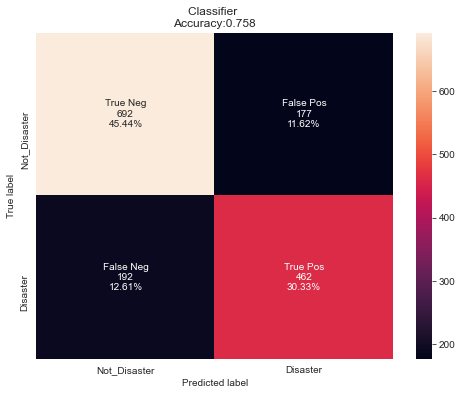

________________________________________________________________________________


In [160]:
# group / ensemble of models
clf1 = LinearSVC(C=0.001, loss='hinge')
clf2 = MultinomialNB(alpha=25)
clf3 = LogisticRegression(C=0.09, penalty='l1', solver='saga')

ehclf = VotingClassifier(estimators = [('LSVC', clf1), ('MNB', clf2), ('LR', clf3)], voting ='hard')

# Voting Classifier with hard voting
classifier_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=4000)),
    ('ss', StandardScaler(with_mean=False)),
    ('classifier', ehclf)
])
classifier_pipeline.fit(X_train, y_train)
y_pred = classifier_pipeline.predict(X_validation)
  
# using accuracy_score metric to predict accuracy
score = accuracy_score(y_validation.values, y_pred)
recall = recall_score(y_validation.values, y_pred)
print("Hard Voting Score", score*100,'%')
print("Hard Voting Recall", recall*100,'%')

cm = confusion_matrix(y_validation.values, y_pred) 
cm_df = pd.DataFrame(cm, index=['Not_Disaster', 'Disaster'], columns=['Not_Disaster','Disaster'])
    
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print("Classification Report\n")
print(classification_report(y_validation.values, y_pred, target_names=['Not Disaster','Disaster']))
print("-"*80)
print("Confusion Matrix\n")
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=labels, fmt='')
plt.title('Classifier \nAccuracy:{0:.3f}'.format(accuracy_score(y_validation.values, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(black("_"*80, ['bold']))